In [2]:
from google.colab import drive
drive.mount('/content/drive/')

import tensorflow as tf
print (tf.test.gpu_device_name())

import sys
sys.path.append("/content/drive/My Drive/Colab/Research - EE5003/Phase 1 - Comparison of forecasting technique/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/device:GPU:0


# **Data Preprocessing**

In [3]:
import time
import calendar
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
sns.set(style="whitegrid")

### **Feature Engineering**

In [4]:
# Find last Monday for holiday
def last_mon_date(year, month):
  """
  Returns a matrix representing a month’s calendar
  Each row represents a week; days outside of the month a represented by zeros
  Each week begins with Monday
  """
  cal = calendar.monthcalendar(year, month)
  last_mon_date = cal[4][0] if (cal[4][0] > 0) else cal[3][0]
  return str(year)+"-"+str(month)+"-"+str(last_mon_date)

def feature_engineering(df):
  
  df["time"] = df["timestamp"].apply(lambda x: datetime.datetime.strptime(x, "%m%d%Y %H:%M")) # Convert to timestamp from string 
  #df = df.set_index(["time"])

  df["Year"] = df["time"].apply(lambda x: x.year)
  df["Month"] = df["time"].apply(lambda x: x.month)
  df["Day"] = df["time"].apply(lambda x: x.day)
  df["Weekday"] = df["time"].apply(lambda x: x.weekday() + 1) # To adjust to 1 to 7 instead of 0 to 6
  df["Week"] = df["Day"].apply(lambda x: (x-1)//7+1)
  df["Weekend"] = df["Weekday"].apply(lambda x: 1 if x>=6 else 0) # Apply function to the column (default: axis=0)
  df["Hour"] = df["time"].apply(lambda x: x.hour)

  # Find last Monday in May
  unique_year = df["Year"].unique()
  last_mon_may = []
  for i in range(0, unique_year.shape[0], 1):
    last_mon_may.append(last_mon_date(unique_year[i], 5))
  last_mon_may = [time.mktime(datetime.datetime.strptime(x,"%Y-%m-%d").timetuple()) for x in last_mon_may] # Convert to timestamp

  df["Holiday"] = 0
  df["Holiday"] = df["time"].apply(lambda x: 1 if (datetime.datetime.timestamp(x) in last_mon_may) else 0)
  df["Holiday"].loc[(df["Month"] == 1) & (df["Day"] == 1)] = 1 # Remember () for condition
  df["Holiday"].loc[(df["Month"] == 12) & (df["Day"] == 25)] = 1
  df["Holiday"].loc[(df["Month"] == 11) & (df["Day"] == 11)] = 1
  df["Holiday"].loc[(df["Month"] == 7) & (df["Day"] == 4)] = 1
  df["Holiday"].loc[(df["Month"] == 1) & (df["Week"] == 3) & (df["Weekday"] == 1)] = 1
  df["Holiday"].loc[(df["Month"] == 2) & (df["Week"] == 3) & (df["Weekday"] == 1)] = 1 
  df["Holiday"].loc[(df["Month"] == 11) & (df["Week"] == 4) & (df["Weekday"] == 4)] = 1
  df["Holiday"].loc[(df["Month"] == 10) & (df["Week"] == 2) & (df["Weekday"] == 1)] = 1
  df["Holiday"].loc[(df["Month"] == 9) & (df["Week"] == 1) & (df["Weekday"] == 1)] = 1  

  df_sub = pd.get_dummies(df["Month"], drop_first=True, prefix="Month_")
  df_sub2 = pd.get_dummies(df["Weekday"], drop_first=True, prefix="Weekday_")
  df_sub3 = pd.get_dummies(df["Hour"], drop_first=True, prefix="Hour_")
  df = pd.concat([df, df_sub, df_sub2, df_sub3], axis=1)
  df = df.drop(["timestamp"], axis=1)

  return df

In [5]:
# os.listdir("/content/drive/My Drive/Colab/Research - EE5003")
df = pd.read_csv("/content/drive/My Drive/Colab/Research - EE5003/Final Modified Data_Rev2.csv")
df = feature_engineering(df)
df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

,PV (kWh),Load (kWh),price (cents/kWh),time,Year,Month,Day,Weekday,Week,Weekend,Hour,Holiday,Month__2,Month__3,Month__4,Month__5,Month__6,Month__7,Month__8,Month__9,Month__10,Month__11,Month__12,Weekday__2,Weekday__3,Weekday__4,Weekday__5,Weekday__6,Weekday__7,Hour__1,Hour__2,Hour__3,Hour__4,Hour__5,Hour__6,Hour__7,Hour__8,Hour__9,Hour__10,Hour__11,Hour__12,Hour__13,Hour__14,Hour__15,Hour__16,Hour__17,Hour__18,Hour__19,Hour__20,Hour__21,Hour__22,Hour__23
0,0.0,2667.0,43.17,2011-01-01 00:00:00,2011,1,1,6,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,2525.0,36.24,2011-01-01 01:00:00,2011,1,1,6,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.0,2417.0,34.64,2011-01-01 02:00:00,2011,1,1,6,1,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0,2373.0,33.76,2011-01-01 03:00:00,2011,1,1,6,1,1,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.0,2374.0,33.08,2011-01-01 04:00:00,2011,1,1,6,1,1,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Visualization**

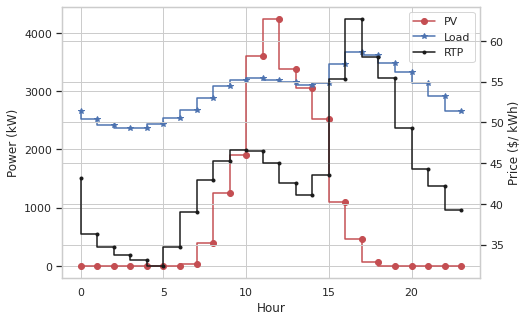

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (7.5,5))
ax2 = ax.twinx()
PV_plot = ax.step(np.arange(24), df.iloc[0:24,0], 'ro-', label = "PV")
load_plot = ax.step(np.arange(24), df.iloc[0:24,1], 'b*-', label = "Load")
price_plot = ax2.step(np.arange(24), df.iloc[0:24,2], 'k.-', label = "RTP")

# Display all label in one box
plots = PV_plot + load_plot + price_plot
labels = [plot.get_label() for plot in plots]
ax.legend(plots, labels, loc = 0)
ax.set_xlabel("Hour")
ax.set_ylabel("Power (kW)")
ax2.set_ylabel("Price ($/ kWh)")

plt.show()

### **Normalization**

In [7]:
# MinMaxScaler = StandardScaler(with_mean = False)

# The mean is not shifted to zero-centered
sc_price = StandardScaler(with_mean=False)
price = sc_price.fit_transform(df.iloc[:,2:3].values)

sc_energy = StandardScaler(with_mean=False)
pv = sc_energy.fit_transform(df.iloc[:,0:1].values)
load = sc_energy.transform(df.iloc[:,1:2].values)

x = np.concatenate([pv, load, price], axis = -1)

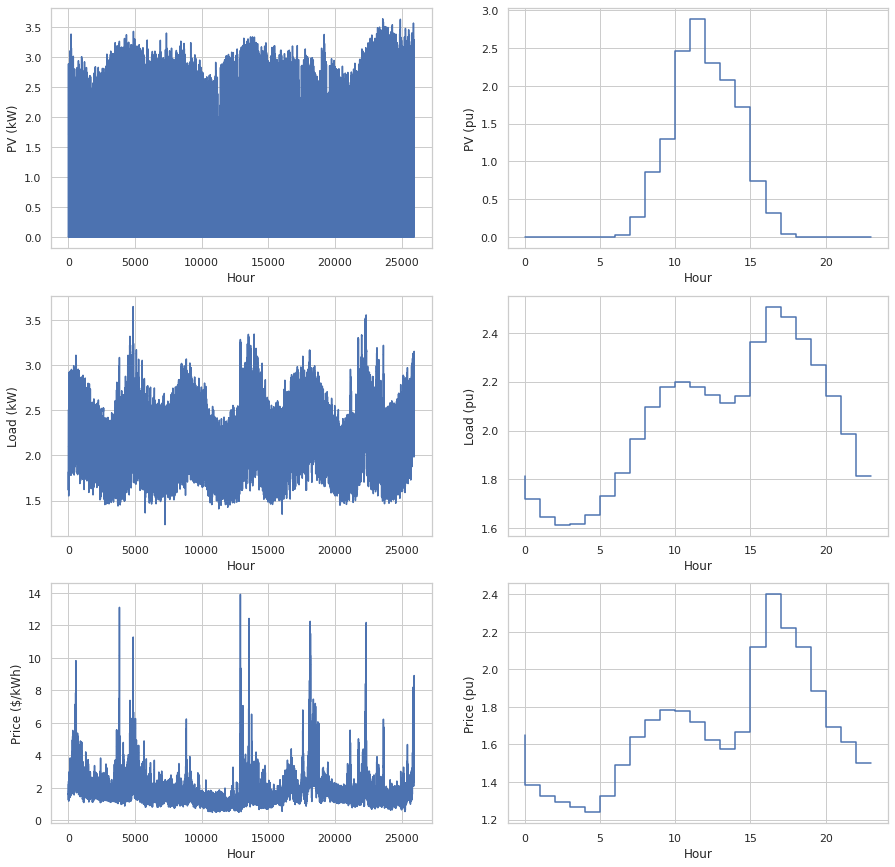

In [8]:
fig, ax = plt.subplots(3, 2, figsize = (15, 15))

ax[0, 0].step(np.arange(len(x[:,0])), x[:,0])
ax[0, 0].set_xlabel("Hour")
ax[0, 0].set_ylabel("PV (kW)")
ax[0, 1].step(np.arange(len(x[0:24,0])), x[0:24,0])
ax[0, 1].set_xlabel("Hour")
ax[0, 1].set_ylabel("PV (pu)")

ax[1, 0].step(np.arange(len(x[:,1])), x[:,1])
ax[1, 0].set_xlabel("Hour")
ax[1, 0].set_ylabel("Load (kW)")
ax[1, 1].step(np.arange(len(x[0:24,1])), x[0:24,1])
ax[1, 1].set_xlabel("Hour")
ax[1, 1].set_ylabel("Load (pu)")

ax[2, 0].step(np.arange(len(x[:,2])), x[:,2])
ax[2, 0].set_xlabel("Hour")
ax[2, 0].set_ylabel("Price ($/kWh)")
ax[2, 1].step(np.arange(len(x[0:24,2])), x[0:24,2])
ax[2, 1].set_xlabel("Hour")
ax[2, 1].set_ylabel("Price (pu)")

plt.show()

### **Train test split & generate sequential data**

In [9]:
def get_sequential_data(timesteps_in, timesteps_out, serial_data, feature_data):

  x, x2, y, y2 = [], [], [], []
  for i in range (timesteps_in, len(serial_data)-timesteps_out+1, 1):
    x.append(serial_data[i-timesteps_in:i])
    x2.append(feature_data[i-timesteps_in:i])
    y.append(serial_data[i:i+timesteps_out])
    y2.append(feature_data[i:i+timesteps_out])

  # Samples, timestep, features
  x, x2, y, y2 = np.array(x), np.array(x2), np.array(y), np.array(y2)
  x = np.expand_dims(x, axis=-1)
  y = np.expand_dims(y, axis=-1)
  x = np.concatenate((x, x2), axis=-1)
  y = np.concatenate((y, y2), axis=-1)

  return x, y

In [10]:
def get_split_data(timesteps_in, timesteps_out, sequential_data, feature_data):

  x, y =  get_sequential_data(timesteps_in, timesteps_out, sequential_data, feature_data)
  x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=42)
  x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=0.5, shuffle=True, random_state=42)

  return x_train, x_valid, x_test, y_train, y_valid, y_test

In [11]:
# 2 weeks of lagged observation to predict next 24 hours
timesteps_in = 2 * 7 * 24
timesteps_out = 24

# 3 items to be predicted
items = ["PV", "Load", "Price"]

# **Prediction**



In [12]:
"""
1. The dataset is split into training, validation and testing set.
2. For each sample in the dataset, there are 41 features, load and one-hot 
   encoded months, weekdays of the week and hours of the day, of two weeks 
   (the previous 336-hour) prior to the target prediction period (the next 24-hour).
3. The shape of the set - (# samples, # timesteps, # features) = (# samples, 336, 41)
"""

item_no = 1
x_train, x_valid, x_test, y_train, y_valid, y_test =  get_split_data(timesteps_in,
                                                                     timesteps_out, 
                                                                     x[:, item_no], 
                                                                     df.iloc[:, 12:].values)

In [13]:
directory = "/content/drive/My Drive/Colab/Research - EE5003/Phase 1 - Comparison of forecasting technique/Load - Model Weights/"

### **LSTM**



In [14]:
from lstm import lstm_model
from sklearn.metrics import mean_absolute_error as mae

In [15]:
"""
1. The shape of the model input - (# samples, # timesteps, # features) = (# samples, 336, 41)
2. The shape of the model output - (# samples, # timesteps) = (# samples, 24)
"""

lstm_units = 32
num_features = y_train.shape[2]

lstm = lstm_model(lstm_units, timesteps_in, timesteps_out, num_features, directory)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 336, 41)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 336, 32)           9472      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 24)                792       
Total params: 18,584
Trainable params: 18,584
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm.fit_model(x_train[:, :, :], y_train[:, :, 0], x_valid[:, :, :], y_valid[:, :, 0])

Epoch 1/20
280/280 [==============================] - 10s 35ms/step - loss: 0.5084 - val_loss: 0.2801
Epoch 2/20
280/280 [==============================] - 9s 33ms/step - loss: 0.1804 - val_loss: 0.1147
Epoch 3/20
280/280 [==============================] - 9s 33ms/step - loss: 0.0965 - val_loss: 0.0912
Epoch 4/20
280/280 [==============================] - 9s 33ms/step - loss: 0.0856 - val_loss: 0.0819
Epoch 5/20
280/280 [==============================] - 9s 33ms/step - loss: 0.0806 - val_loss: 0.0792
Epoch 6/20
280/280 [==============================] - 9s 33ms/step - loss: 0.0776 - val_loss: 0.0767
Epoch 7/20
280/280 [==============================] - 9s 33ms/step - loss: 0.0754 - val_loss: 0.0751
Epoch 8/20
280/280 [==============================] - 9s 32ms/step - loss: 0.0740 - val_loss: 0.0766
Epoch 9/20
280/280 [==============================] - 9s 33ms/step - loss: 0.0721 - val_loss: 0.0714
Epoch 10/20
280/280 [==============================] - 9s 33ms/step - loss: 0.0707 - val_l

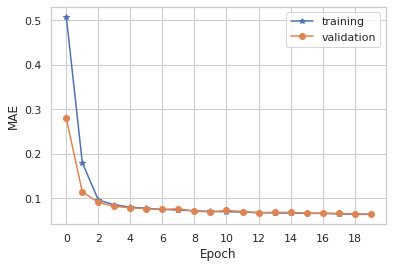

In [ ]:
plt.plot(lstm.history.history["loss"], "-*", label="training")
plt.plot(lstm.history.history["val_loss"], "-o", label="validation")
plt.xticks(np.arange(0, 20, 2), np.arange(0, 20, 2))
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()

Testing MAE: 0.0632 pu



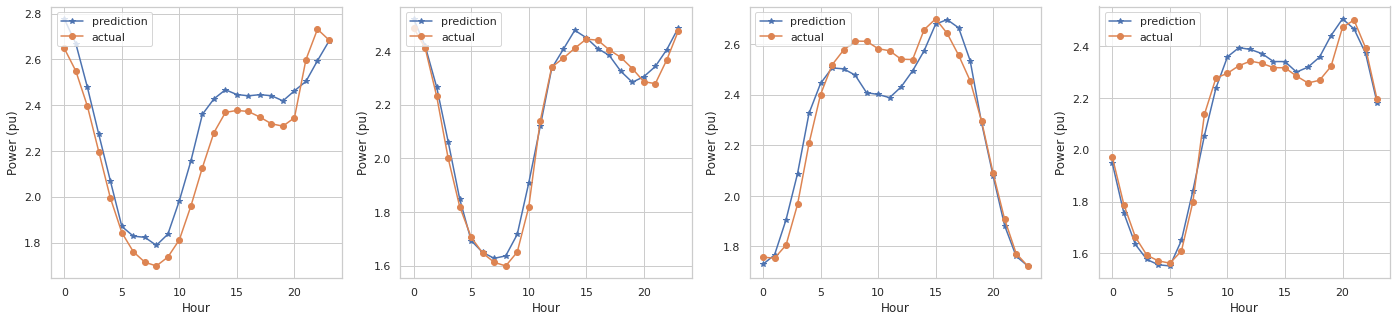

In [16]:
y_train_pred = lstm.predict(x_train[:, :, :])

print ("Testing MAE: {:.4f} pu\n".format(mae(y_train[:, :, 0], y_train_pred)))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(y_train_pred[i], "-*", label="prediction")
  ax.plot(y_train[i, :, 0], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (pu)")
  ax.legend(loc=2)
plt.show()

Testing MAE: 0.0647 pu



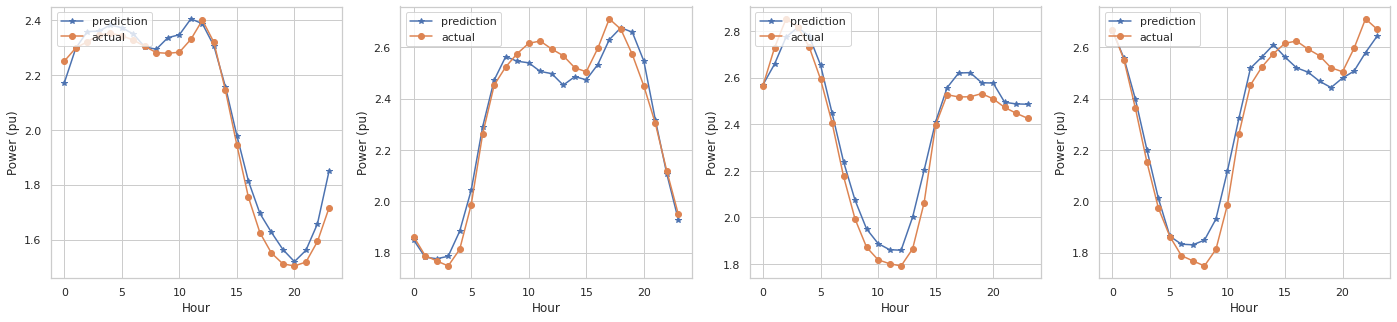

In [17]:
y_test_pred = lstm.predict(x_test[:, :, :])

print ("Testing MAE: {:.4f} pu\n".format(mae(y_test[:, :, 0], y_test_pred)))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(y_test_pred[i], "-*", label="prediction")
  ax.plot(y_test[i, :, 0], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (pu)")
  ax.legend(loc=2)
plt.show()

Testing MAE: 92.8404 W



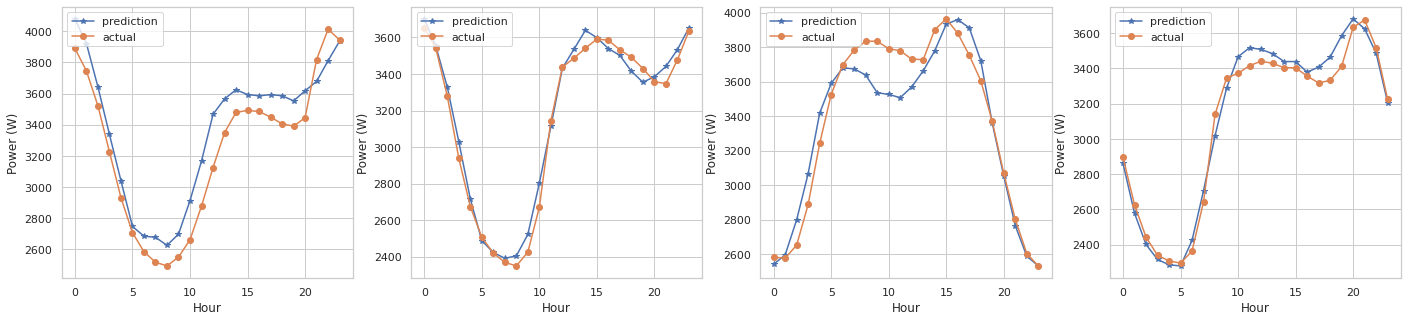

In [18]:
inverse_y_train_pred = sc_energy.inverse_transform(y_train_pred)
inverse_y_train = sc_energy.inverse_transform(y_train[:, :, 0]) 

print ("Testing MAE: {:.4f} W\n".format(mae(inverse_y_train, inverse_y_train_pred)))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(inverse_y_train_pred[i], "-*", label="prediction")
  ax.plot(inverse_y_train[i], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (W)")
  ax.legend(loc=2)
plt.show()

Testing MAE: 95.0809 W



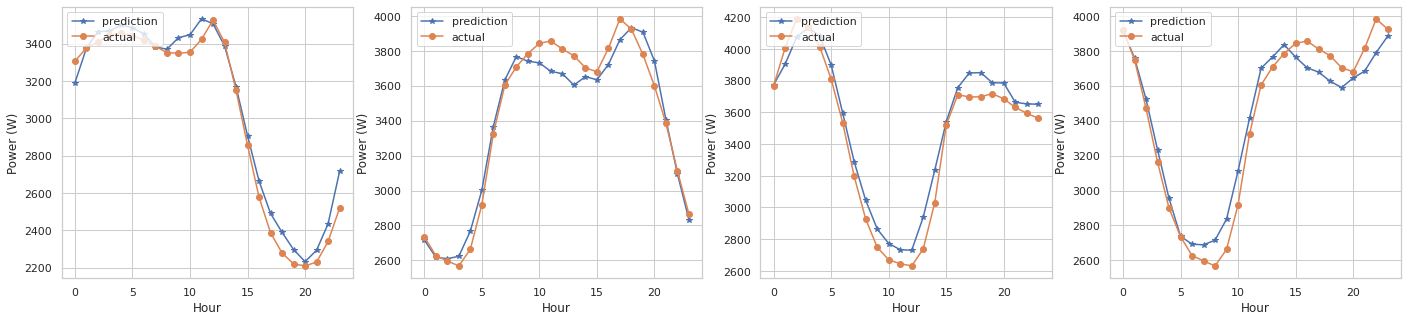

In [19]:
inverse_y_test_pred = sc_energy.inverse_transform(y_test_pred)
inverse_y_test = sc_energy.inverse_transform(y_test[:, :, 0]) 

print ("Testing MAE: {:.4f} W\n".format(mae(inverse_y_test, inverse_y_test_pred)))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(inverse_y_test_pred[i], "-*", label="prediction")
  ax.plot(inverse_y_test[i], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (W)")
  ax.legend(loc=2)
plt.show()

### **Seq2Seq**

In [20]:
from seq2seq import seq2seq_model
from sklearn.metrics import mean_absolute_error as mae

In [21]:
"""
1. The shape of the model input - (# samples, # timesteps, # features) = (# samples, 336, 41)
2. The shape of the model output - (# samples, # timesteps) = (# samples, 24, 1)
"""

encoder_units = 32
decoder_units = 32
num_features = 41

seq2seq = seq2seq_model(encoder_units, decoder_units, timesteps_in, timesteps_out, num_features, directory)

In [ ]:
seq2seq.fit_model(x_train, y_train[:, :, 0:1], x_valid, y_valid[:, :, 0:1])

Epoch 1/20
280/280 [==============================] - 6s 22ms/step - loss: 0.3338 - val_loss: 0.1461
Epoch 2/20
280/280 [==============================] - 6s 20ms/step - loss: 0.1051 - val_loss: 0.0883
Epoch 3/20
280/280 [==============================] - 6s 20ms/step - loss: 0.0807 - val_loss: 0.0761
Epoch 4/20
280/280 [==============================] - 6s 20ms/step - loss: 0.0757 - val_loss: 0.0729
Epoch 5/20
280/280 [==============================] - 6s 20ms/step - loss: 0.0716 - val_loss: 0.0695
Epoch 6/20
280/280 [==============================] - 6s 21ms/step - loss: 0.0694 - val_loss: 0.0683
Epoch 7/20
280/280 [==============================] - 6s 20ms/step - loss: 0.0683 - val_loss: 0.0704
Epoch 8/20
280/280 [==============================] - 6s 20ms/step - loss: 0.0663 - val_loss: 0.0645
Epoch 9/20
280/280 [==============================] - 6s 20ms/step - loss: 0.0648 - val_loss: 0.0645
Epoch 10/20
280/280 [==============================] - 6s 21ms/step - loss: 0.0642 - val_lo

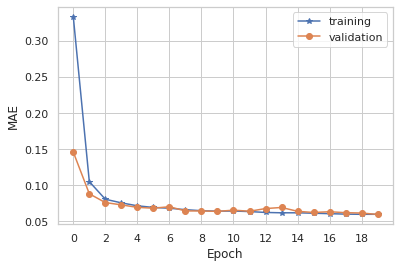

In [ ]:
plt.plot(seq2seq.history.history["loss"], "-*", label="training")
plt.plot(seq2seq.history.history["val_loss"], "-o", label="validation")
plt.xticks(np.arange(0, 20, 2), np.arange(0, 20, 2))
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()

Testing MAE: 0.0581 pu



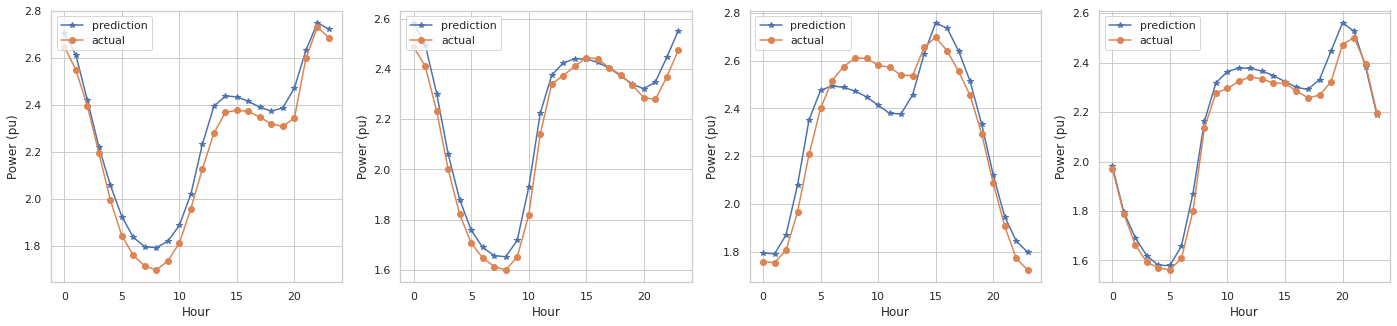

In [22]:
y_train_pred = seq2seq.predict(x_train[:, :, :])

print ("Testing MAE: {:.4f} pu\n".format(mae(y_train[:, :, 0], y_train_pred[:, :, 0])))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(y_train_pred[i], "-*", label="prediction")
  ax.plot(y_train[i, :, 0], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (pu)")
  ax.legend(loc=2)
plt.show()

Testing MAE: 0.0598 pu



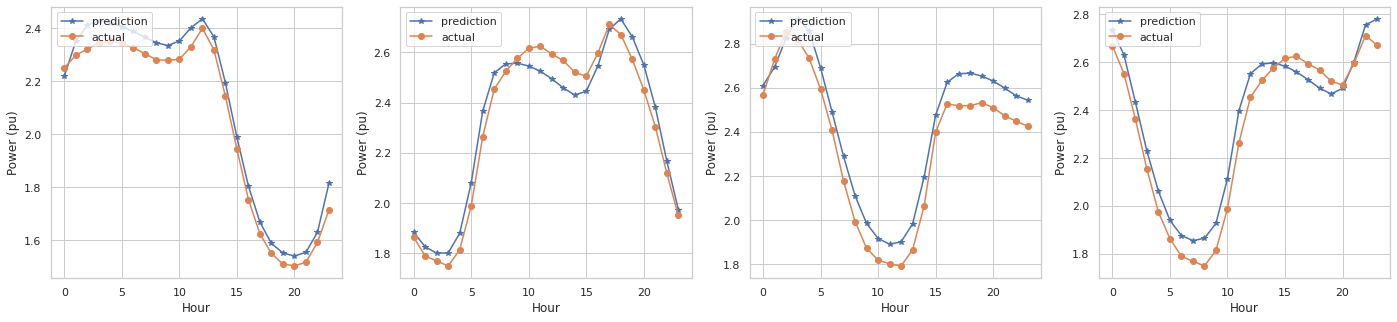

In [23]:
y_test_pred = seq2seq.predict(x_test[:, :, :])

print ("Testing MAE: {:.4f} pu\n".format(mae(y_test[:, :, 0], y_test_pred[:, :, 0])))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(y_test_pred[i], "-*", label="prediction")
  ax.plot(y_test[i, :, 0], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (pu)")
  ax.legend(loc=2)
plt.show()

Testing MAE: 85.3745 W



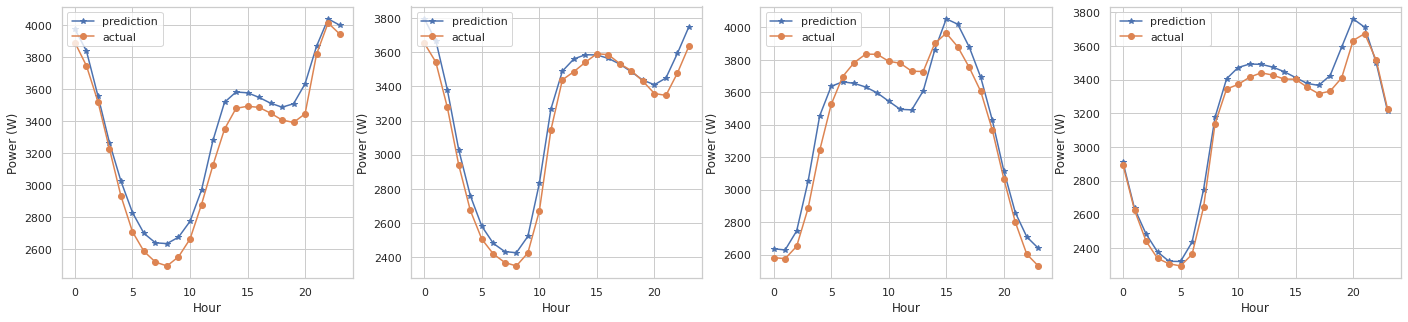

In [24]:
inverse_y_train_pred = sc_energy.inverse_transform(y_train_pred[:, :, 0])
inverse_y_train = sc_energy.inverse_transform(y_train[:, :, 0]) 

print ("Testing MAE: {:.4f} W\n".format(mae(inverse_y_train, inverse_y_train_pred)))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(inverse_y_train_pred[i], "-*", label="prediction")
  ax.plot(inverse_y_train[i], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (W)")
  ax.legend(loc=2)
plt.show()

Testing MAE: 87.8811 W



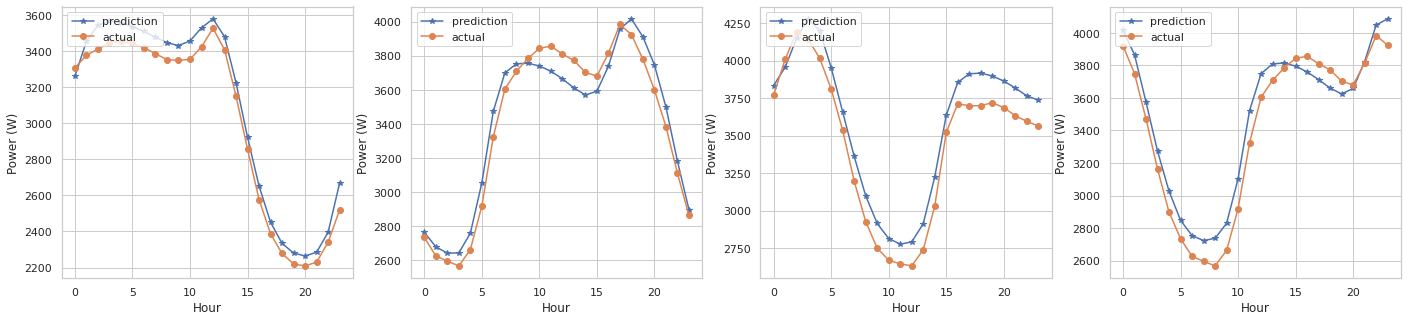

In [25]:
inverse_y_test_pred = sc_energy.inverse_transform(y_test_pred[:, :, 0])
inverse_y_test = sc_energy.inverse_transform(y_test[:, :, 0]) 

print ("Testing MAE: {:.4f} W\n".format(mae(inverse_y_test, inverse_y_test_pred)))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(inverse_y_test_pred[i], "-*", label="prediction")
  ax.plot(inverse_y_test[i], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (W)")
  ax.legend(loc=2)
plt.show()

### **Seq2Seq (Attention)**

In [26]:
from seq2seqatt import Encoder, Decoder
from sklearn.metrics import mean_absolute_error as mae

In [27]:
def loss_function(real, pred):
  loss = tf.keras.losses.MAE(real, pred)
  return tf.reduce_mean(loss) # mean of each sample

In [28]:
def get_batch(inps, tars, batch_size):
    l = len(inps)
    for i in range(0, l, batch_size):
        yield i / batch_size, inps[i:min(i + batch_size, l)], tars[i:min(i + batch_size, l)]

In [29]:
def predict(x_test, y_test):

  inps = x_test.astype(np.float32)
  tars = y_test[:, :, :].astype(np.float32)

  for batch, inp, tar in get_batch(inps, tars, batch_size):
    state_h, state_c = encoder.initialize_state()

    # adjust to suit the current batch size
    state_h, state_c = state_h[:len(inp), :], state_c[:len(inp), :]
    enc_output, state_h, state_c = encoder(inp, state_h, state_c)

    # Use teacher forcing - feed the actual input of the former step for next step prediction
    # Use the feature data of the next step
    dec_input = inp[:, -1:, :] # 41 features input
      
    for t in range(0, timesteps_out):
      predictions, attention_weights, state_h, state_c = decoder(dec_input, enc_output, state_h, state_c)
      dec_input = tf.concat((predictions, tar[:, t:t+1, 1:]), axis=-1) # 41 features input

      if t == 0:
        outputs = predictions
        batch_attentions = attention_weights
      else:
        outputs = tf.concat([outputs, predictions], axis=1)
        batch_attentions = tf.concat([batch_attentions, attention_weights], axis=2)

    if batch == 0:
      y_test_pred = outputs
      attentions = batch_attentions
    else:
      y_test_pred = tf.concat([y_test_pred, outputs], axis=0)
      attentions = tf.concat([attentions, batch_attentions], axis=0)

  return y_test_pred, attentions

In [30]:
def plot_graph(inp, pred, att):

  fig = plt.figure(figsize=(24,8))
  spec = gridspec.GridSpec(ncols=90, nrows=100)

  top_ax = fig.add_subplot(spec[0:15, 7:73])
  left_ax = fig.add_subplot(spec[25:, 0:5])
  right_ax = fig.add_subplot(spec[25:, 7:])

  top_ax.plot(inp)
  top_ax.set_xlim([0, timesteps_in])
  top_ax.set_xticks(range(0, timesteps_in, 8))
  top_ax.set_xticklabels(range(0, timesteps_in, 8))

  left_ax.plot(pred, range(0, timesteps_out))
  left_ax.set_yticks(range(0, timesteps_out, 2))
  left_ax.set_yticklabels(range(0, timesteps_out, 2))
  left_ax.invert_yaxis()

  sns.heatmap(tf.transpose(att), cmap="viridis", ax=right_ax)
  right_ax.set_xticks(range(0, timesteps_in, 8))
  right_ax.set_xticklabels(range(0, timesteps_in, 8))
  right_ax.set_yticks(range(0, timesteps_out, 2))
  right_ax.set_yticklabels(range(0, timesteps_out, 2))

  plt.show()

In [31]:
"""
1. The shape of the encoder input - (# samples, # timesteps, # features) = (# samples, 336, 41)
2. The shape of the decoder input - (# samples, 1, # features) = (# samples, 1, 41)
3. Feed the features of the previous timestep for the prediction of current timestep
4. No teacher forcing is used - better result achieved
"""

# Model parameters
encoder_units = 32
decoder_units = 32
conv1d_units = 16

# Training parameters
optimizer = tf.keras.optimizers.Adam(0.0001)
epochs = 30
batch_size = 128
val_loss_bef = np.inf

encoder = Encoder(encoder_units, conv1d_units, batch_size, directory)
decoder = Decoder(decoder_units, conv1d_units, directory)

In [ ]:
inps = x_train.astype(np.float32)
tars = y_train[:, :, :].astype(np.float32)

for epoch in range(epochs):
  start = time.time()
  train_loss = 0

  for batch, inp, tar in get_batch(inps, tars, batch_size):
    loss = 0
    state_h, state_c = encoder.initialize_state()
    
    with tf.GradientTape() as tape:
      # Adjust to suit the current batch size
      state_h, state_c = state_h[:len(inp), :], state_c[:len(inp), :]
      enc_output, state_h, state_c = encoder(inp, state_h, state_c)

      # Use teacher forcing - feed the actual input of the former step for next step prediction
      # Use the feature data of the next step
      dec_input = inp[:, -1:, :] # 41 features input
      
      # Use teacher forcing - feed the actual input of the former step for next step prediction
      for t in range(0, timesteps_out):
        #print (t, dec_input.shape)
        predictions, _, state_h, state_c = decoder(dec_input, enc_output, state_h, state_c)
        loss += loss_function(tar[:, t:t+1, 0:1], predictions)
        dec_input = tar[:, t:t+1, :] # 41 features input
  
    train_loss += (loss / timesteps_out)
    
    # Training with the loss 
    variables = encoder.variables + decoder.variables
    gradients = tape.gradient(loss, variables)   
    optimizer.apply_gradients(zip(gradients, variables))
  
  y_valid_pred, _ = predict(x_valid, y_valid)
  val_loss = mae(y_valid[:, :, 0], y_valid_pred[:, :, 0])
  
  # Save the weights of best model
  if val_loss < val_loss_bef:
    encoder.save_weights(encoder.weights_dir)
    decoder.save_weights(decoder.weights_dir)
    val_loss_bef = val_loss

  print('Epoch {} training loss - {:.4f}, validation loss - {:.4f}'.format(epoch + 1, train_loss / (batch + 1), val_loss))
  print('Best validation loss - {:.4f}, time taken for 1 epoch {:.4f} sec\n'.format(val_loss_bef, time.time() - start))

Epoch 1 training loss - 1.1921, validation loss - 0.3934
Best validation loss - 0.3934, time taken for 1 epoch 50.9434 sec

Epoch 2 training loss - 0.3313, validation loss - 0.2728
Best validation loss - 0.2728, time taken for 1 epoch 50.2574 sec

Epoch 3 training loss - 0.2398, validation loss - 0.2116
Best validation loss - 0.2116, time taken for 1 epoch 50.1748 sec

Epoch 4 training loss - 0.1721, validation loss - 0.1592
Best validation loss - 0.1592, time taken for 1 epoch 50.2731 sec

Epoch 5 training loss - 0.1224, validation loss - 0.1299
Best validation loss - 0.1299, time taken for 1 epoch 49.5273 sec

Epoch 6 training loss - 0.0989, validation loss - 0.1172
Best validation loss - 0.1172, time taken for 1 epoch 49.6215 sec

Epoch 7 training loss - 0.0872, validation loss - 0.1096
Best validation loss - 0.1096, time taken for 1 epoch 48.9832 sec

Epoch 8 training loss - 0.0795, validation loss - 0.1048
Best validation loss - 0.1048, time taken for 1 epoch 49.2471 sec

Epoch 9 

Training MAE: 0.0691 pu



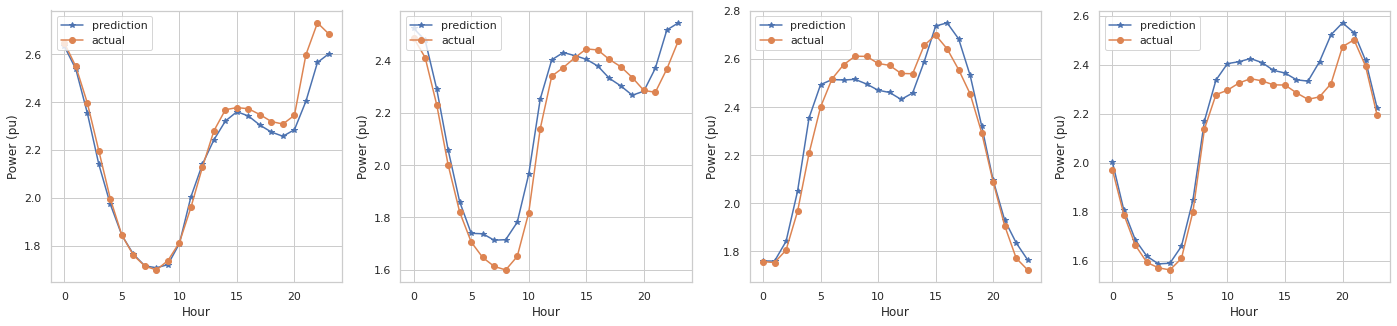

In [32]:
encoder.load_weights(encoder.weights_dir)
decoder.load_weights(decoder.weights_dir)

y_train_pred, attentions = predict(x_train, y_train)
print ("Training MAE: {:.4f} pu\n".format(mae(y_train[:, :, 0], y_train_pred[:, :, 0])))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(y_train_pred[i], "-*", label="prediction")
  ax.plot(y_train[i, :, 0], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (pu)")
  ax.legend(loc=2)
plt.show()

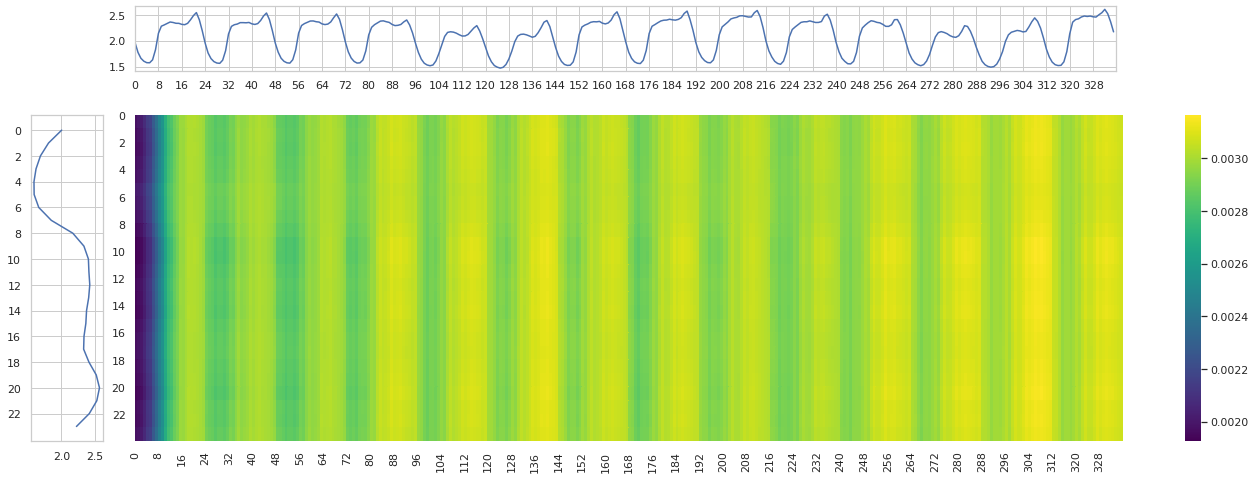

In [33]:
idx = 3000
inp = x_train[idx, :, 0]
pred = y_train_pred[idx, :, 0]
att = attentions[idx]

plot_graph(inp, pred, att)

Testing MAE: 0.0711 pu



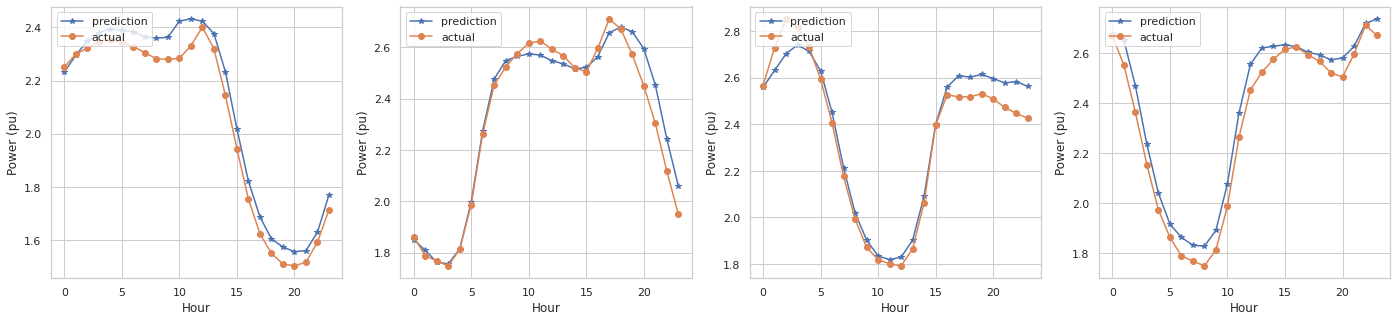

In [34]:
encoder.load_weights(encoder.weights_dir)
decoder.load_weights(decoder.weights_dir)

y_test_pred, attentions = predict(x_test, y_test)
print ("Testing MAE: {:.4f} pu\n".format(mae(y_test[:, :, 0], y_test_pred[:, :, 0])))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(y_test_pred[i], "-*", label="prediction")
  ax.plot(y_test[i, :, 0], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (pu)")
  ax.legend(loc=2)
plt.show()

Testing MAE: 101.4740 W



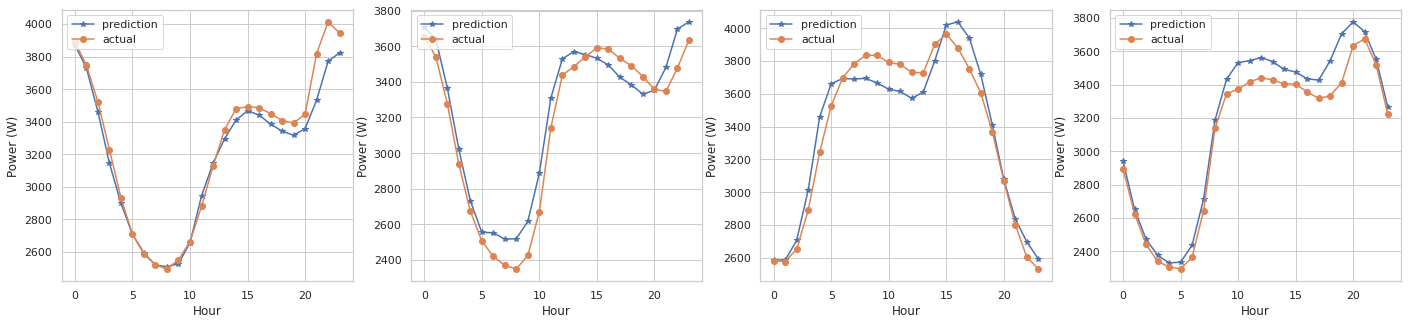

In [35]:
inverse_y_train_pred = sc_energy.inverse_transform(y_train_pred[:, :, 0])
inverse_y_train = sc_energy.inverse_transform(y_train[:, :, 0]) 

print ("Testing MAE: {:.4f} W\n".format(mae(inverse_y_train, inverse_y_train_pred)))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(inverse_y_train_pred[i], "-*", label="prediction")
  ax.plot(inverse_y_train[i], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (W)")
  ax.legend(loc=2)
plt.show()

Testing MAE: 104.3825 W



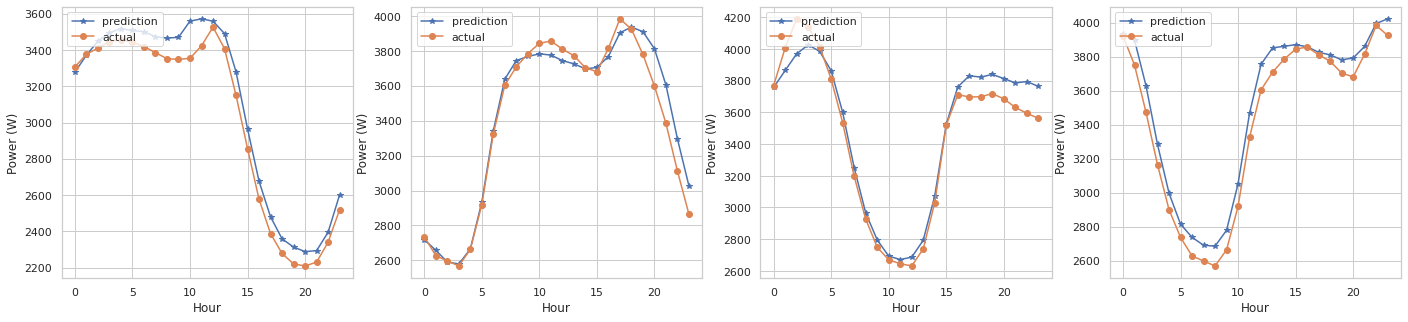

In [36]:
inverse_y_test_pred = sc_energy.inverse_transform(y_test_pred[:, :, 0])
inverse_y_test = sc_energy.inverse_transform(y_test[:, :, 0]) 

print ("Testing MAE: {:.4f} W\n".format(mae(inverse_y_test, inverse_y_test_pred)))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(inverse_y_test_pred[i], "-*", label="prediction")
  ax.plot(inverse_y_test[i], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (W)")
  ax.legend(loc=2)
plt.show()

### **Transformer with kernel of length 5**

In [37]:
from tx import tx_model
from sklearn.metrics import mean_absolute_error as mae

In [38]:
"""
1. The shape of the encoder input - (# samples, # timesteps, # features) = (# samples, 336, 41) (the past 336 hours)
2. The shape of the decoder input - (# samples, 24, # features) = (# samples, 24, 41) (the past 24 hours)
"""

# user defined transformer parameters
num_layers = 1
d_model = 64
num_heads = 4
dff = 64
kernel_size = 5
dropout_rate = 0.1

tx = tx_model(num_layers, d_model, num_heads, dff,
              kernel_size, dropout_rate, timesteps_in, 
              timesteps_out, items[item_no], directory)

In [ ]:
tx.fit_model(x_train[:, :, :], y_train[:, :, :], x_valid[:, :, :], y_valid[:, :, :])

Epoch 1 training loss - 0.4019, validation loss - 0.1838
Best validation loss - 0.1838, time taken for 1 epoch 25.5830 sec

Epoch 2 training loss - 0.1930, validation loss - 0.1338
Best validation loss - 0.1338, time taken for 1 epoch 25.5762 sec

Epoch 3 training loss - 0.1479, validation loss - 0.1202
Best validation loss - 0.1202, time taken for 1 epoch 25.4392 sec

Epoch 4 training loss - 0.1273, validation loss - 0.1025
Best validation loss - 0.1025, time taken for 1 epoch 25.4365 sec

Epoch 5 training loss - 0.1151, validation loss - 0.0938
Best validation loss - 0.0938, time taken for 1 epoch 25.2669 sec

Epoch 6 training loss - 0.1066, validation loss - 0.0909
Best validation loss - 0.0909, time taken for 1 epoch 25.1938 sec

Epoch 7 training loss - 0.1012, validation loss - 0.0811
Best validation loss - 0.0811, time taken for 1 epoch 25.2496 sec

Epoch 8 training loss - 0.0964, validation loss - 0.0832
Best validation loss - 0.0811, time taken for 1 epoch 25.3327 sec

Epoch 9 

In [ ]:
tx.model.summary()

Model: "transformer_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (Encoder)          multiple                  71168     
_________________________________________________________________
decoder_1 (Decoder)          multiple                  120704    
_________________________________________________________________
dense_21 (Dense)             multiple                  65        
Total params: 191,937
Trainable params: 191,937
Non-trainable params: 0
_________________________________________________________________


Training MAE: 0.0573 pu



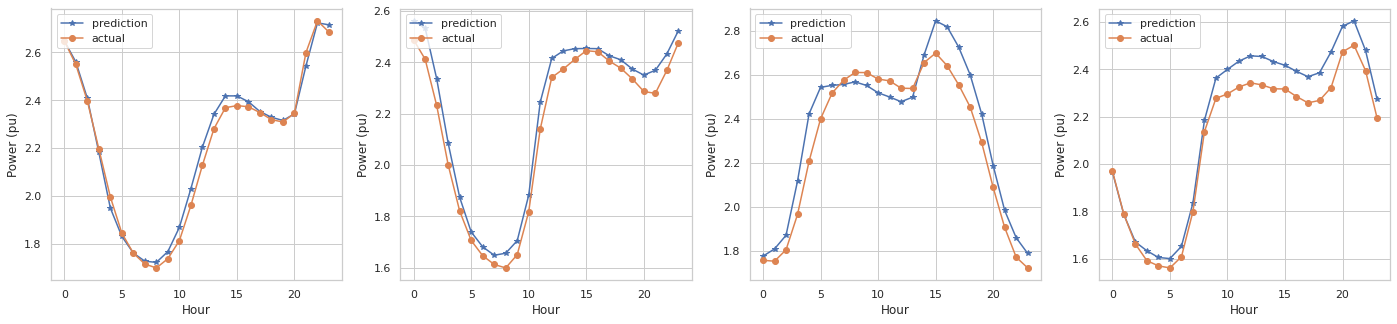

In [39]:
# attention_weights are saved for the last batch only
y_train_pred, attention_weights, decoder_input = tx.predict(x_train[:, :, :], False)

print ("Training MAE: {:.4f} pu\n".format(mae(y_train[:, :, 0], y_train_pred[:, :, 0])))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(y_train_pred[i], "-*", label="prediction")
  ax.plot(y_train[i, :, 0], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (pu)")
  ax.legend(loc=2)
plt.show()

Testing MAE: 0.0599 pu



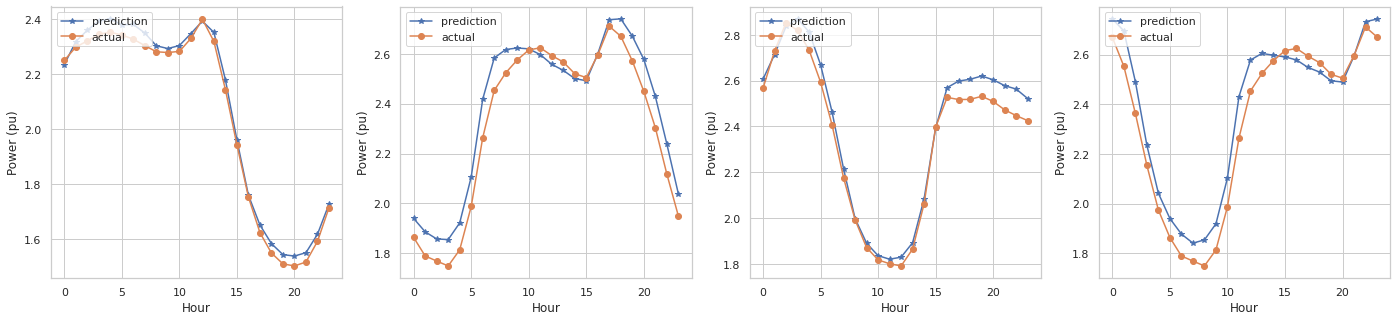

In [40]:
# attention_weights are saved for the last batch only
y_test_pred, attention_weights, decoder_input = tx.predict(x_test[:, :, :], False)

print ("Testing MAE: {:.4f} pu\n".format(mae(y_test[:, :, 0], y_test_pred[:, :, 0])))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(y_test_pred[i], "-*", label="prediction")
  ax.plot(y_test[i, :, 0], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (pu)")
  ax.legend(loc=2)
plt.show()

Testing MAE: 84.1338 W



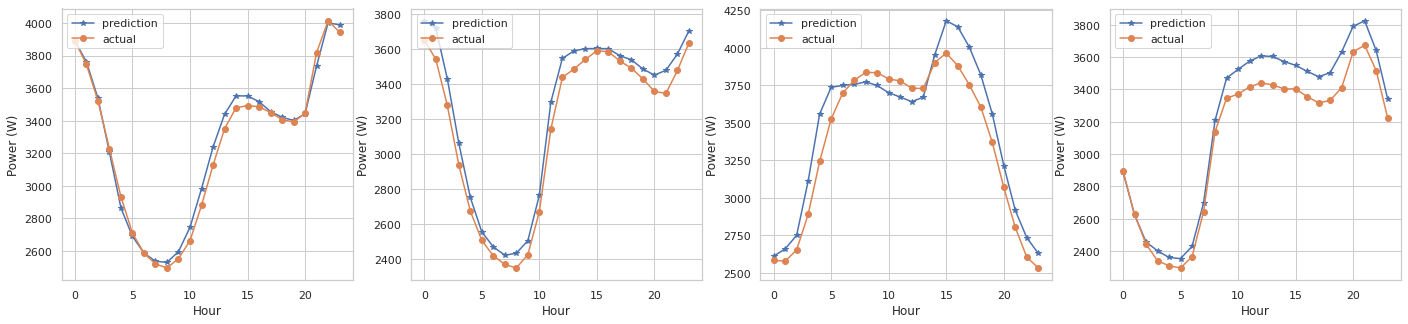

In [41]:
inverse_y_train_pred = sc_energy.inverse_transform(y_train_pred[:, :, 0])
inverse_y_train = sc_energy.inverse_transform(y_train[:, :, 0]) 

print ("Testing MAE: {:.4f} W\n".format(mae(inverse_y_train, inverse_y_train_pred)))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(inverse_y_train_pred[i], "-*", label="prediction")
  ax.plot(inverse_y_train[i], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (W)")
  ax.legend(loc=2)
plt.show()

Testing MAE: 88.0499 W



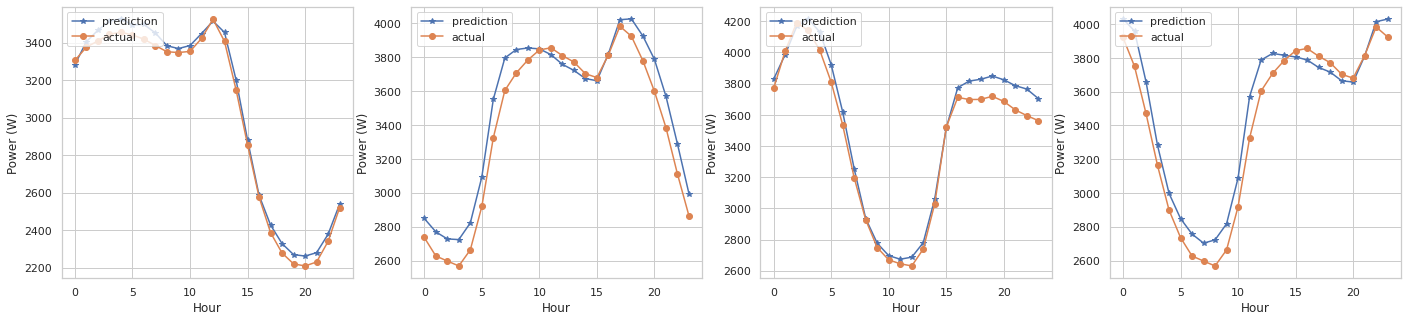

In [42]:
inverse_y_test_pred = sc_energy.inverse_transform(y_test_pred[:, :, 0])
inverse_y_test = sc_energy.inverse_transform(y_test[:, :, 0]) 

print ("Testing MAE: {:.4f} W\n".format(mae(inverse_y_test, inverse_y_test_pred)))

fig = plt.figure(figsize=(24, 5))
for idx, i in enumerate([0, 1000, 2000, 3000]):
  ax = fig.add_subplot(1, 4, idx+1)
  ax.plot(inverse_y_test_pred[i], "-*", label="prediction")
  ax.plot(inverse_y_test[i], "-o", label="actual")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Power (W)")
  ax.legend(loc=2)
plt.show()

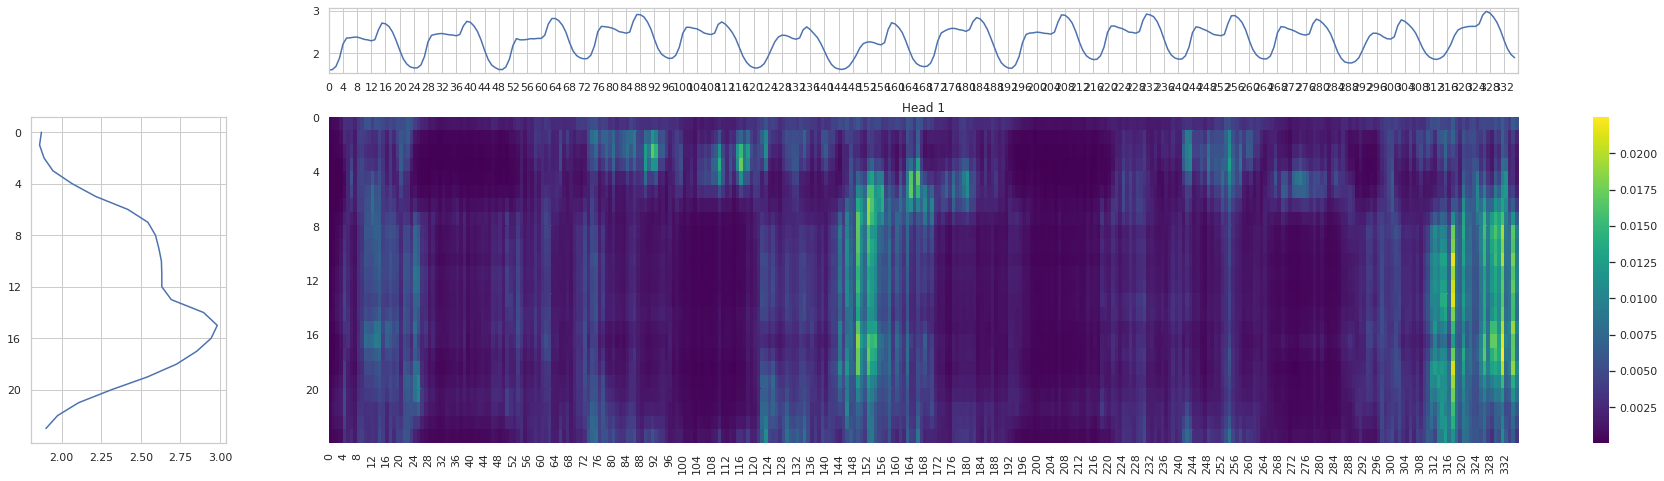

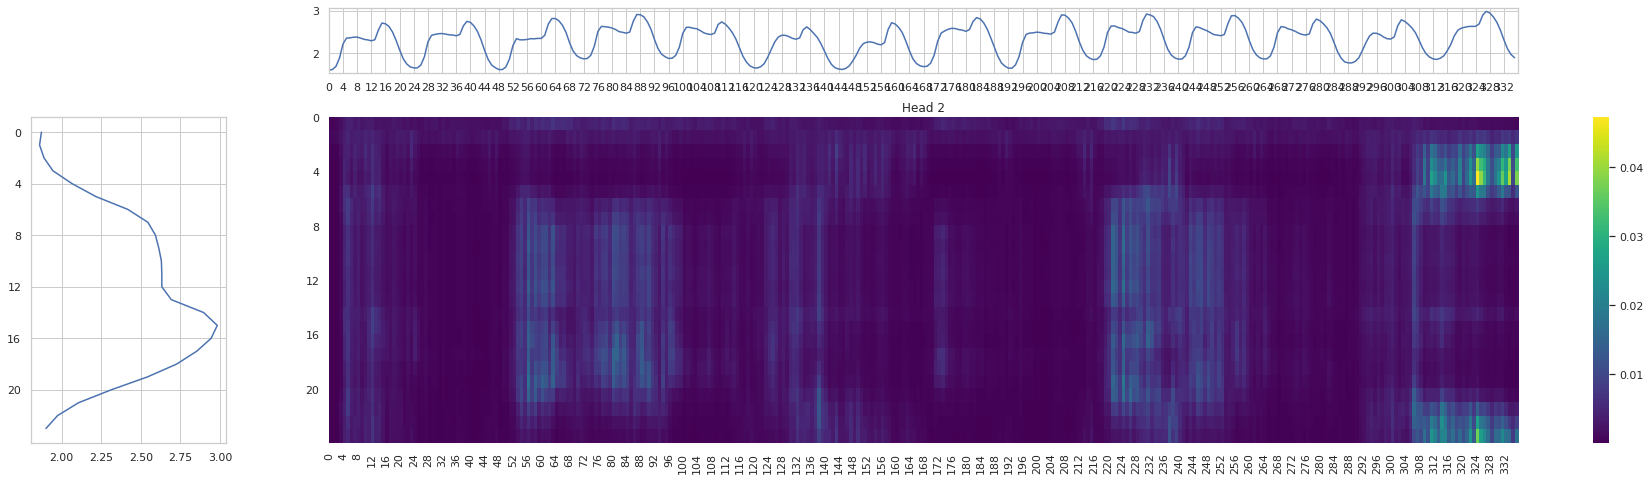

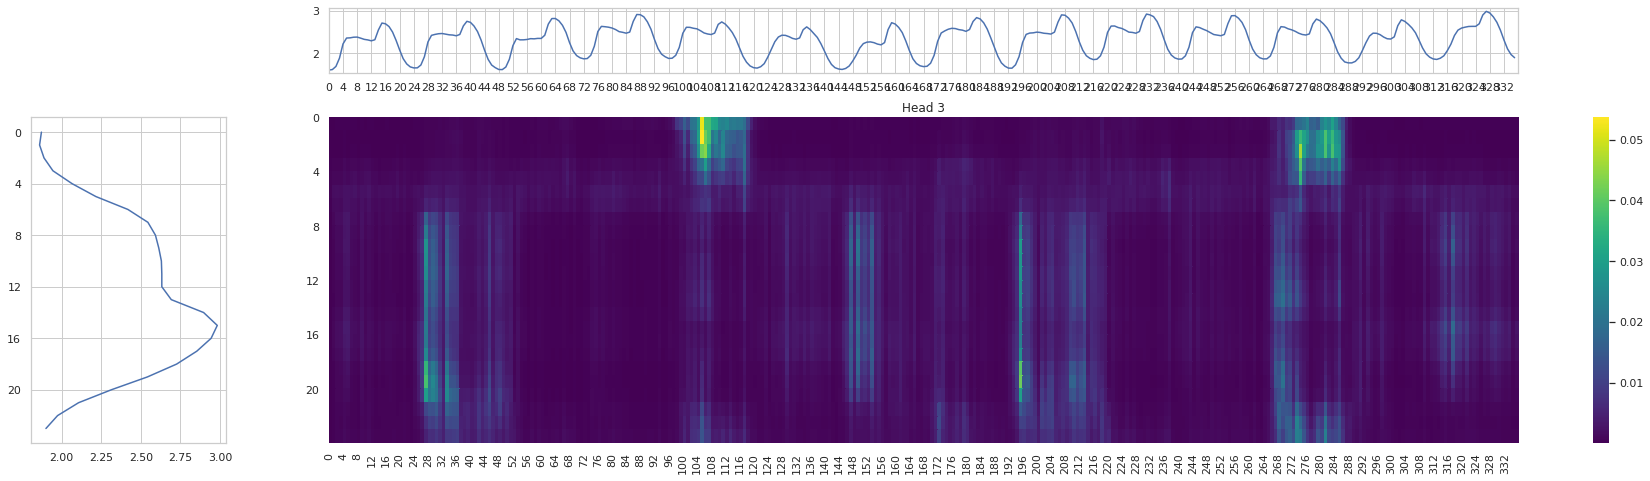

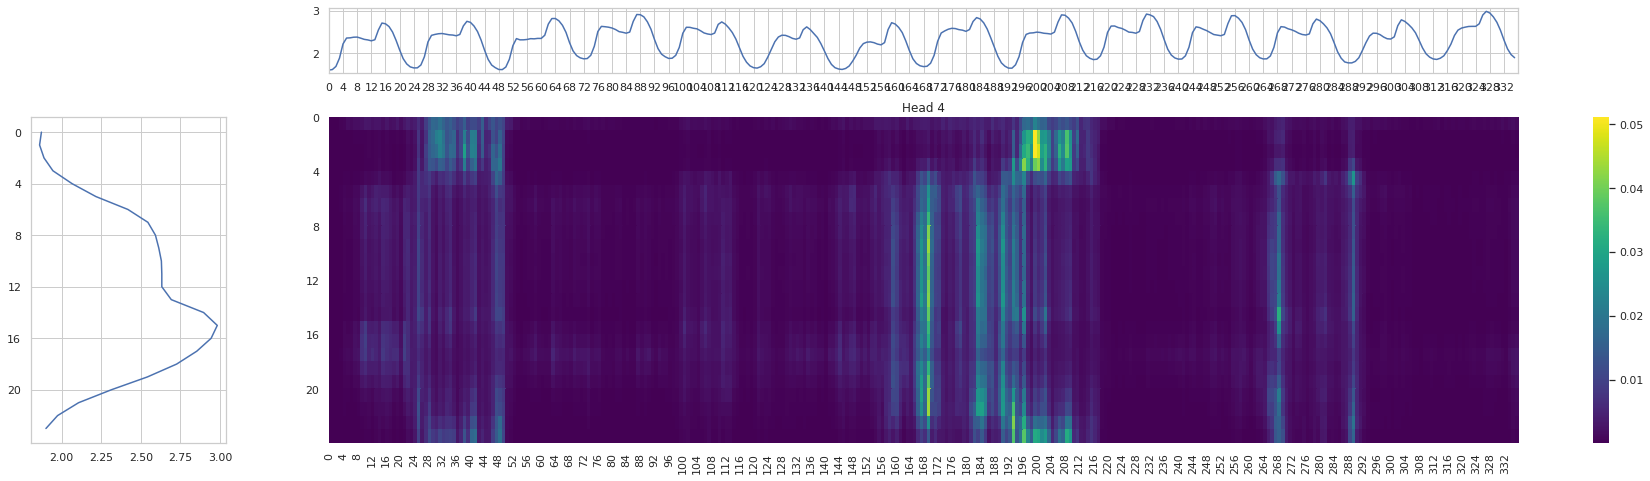

In [ ]:
idx = -10

num_steps_display = timesteps_in

attention = attention_weights
attention = tf.squeeze(attention["decoder_layer1_block2"][idx:idx+1], axis=0)

for head in range(0, num_heads):
  fig = plt.figure(figsize=(32,8))
  spec = gridspec.GridSpec(ncols=90, nrows=100)
  
  top_ax = fig.add_subplot(spec[0:15, 15:75])
  left_ax = fig.add_subplot(spec[25:, 0:10])
  right_ax = fig.add_subplot(spec[25:, 15:])
  
  top_ax.plot(x_train[idx, :num_steps_display, 0])
  top_ax.set_xlim([0, num_steps_display])
  top_ax.set_xticks(range(0, num_steps_display, 4))
  top_ax.set_xticklabels(range(0, num_steps_display, 4))

  left_ax.plot(decoder_input[idx, :, 0], range(0, timesteps_out))
  left_ax.set_yticks(range(0, timesteps_out, 4))
  left_ax.set_yticklabels(range(0, timesteps_out, 4))
  left_ax.invert_yaxis()

  sns.heatmap(attention[head][:, :num_steps_display], cmap="viridis", ax=right_ax)
  right_ax.set_xticks(range(0, num_steps_display, 4))
  right_ax.set_xticklabels(range(0, num_steps_display, 4))
  right_ax.set_yticks(range(0, timesteps_out, 4))
  right_ax.set_yticklabels(range(0, timesteps_out, 4))

  plt.title("Head {}".format(head+1))
  plt.show()

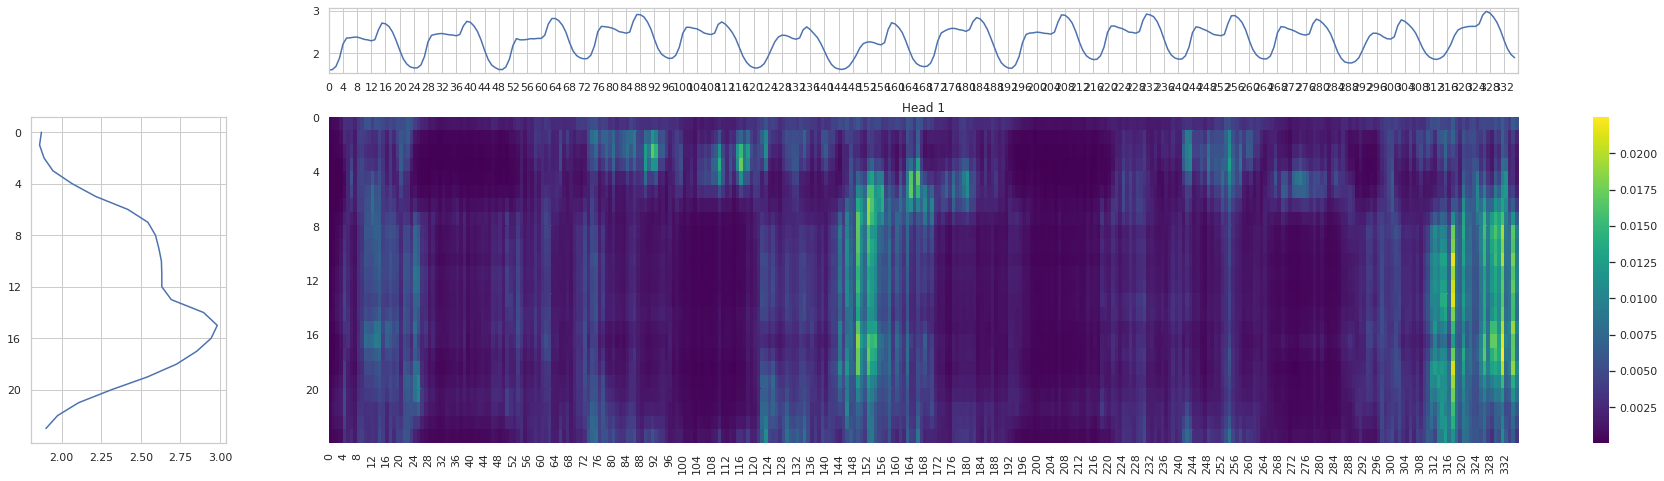

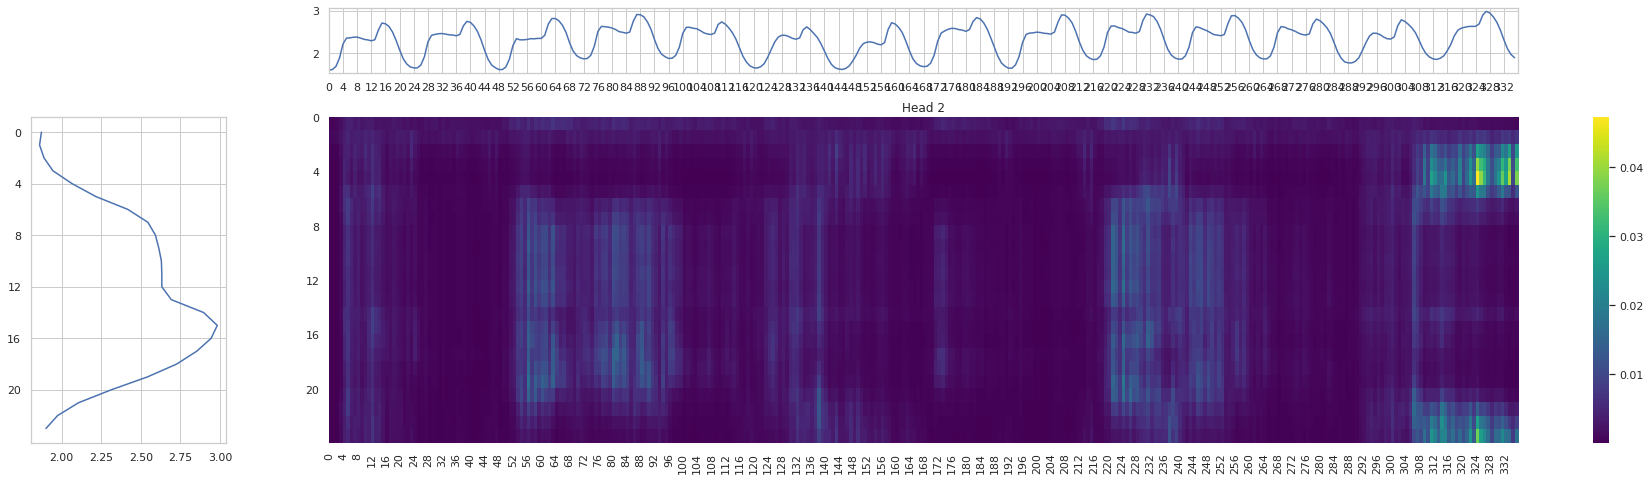

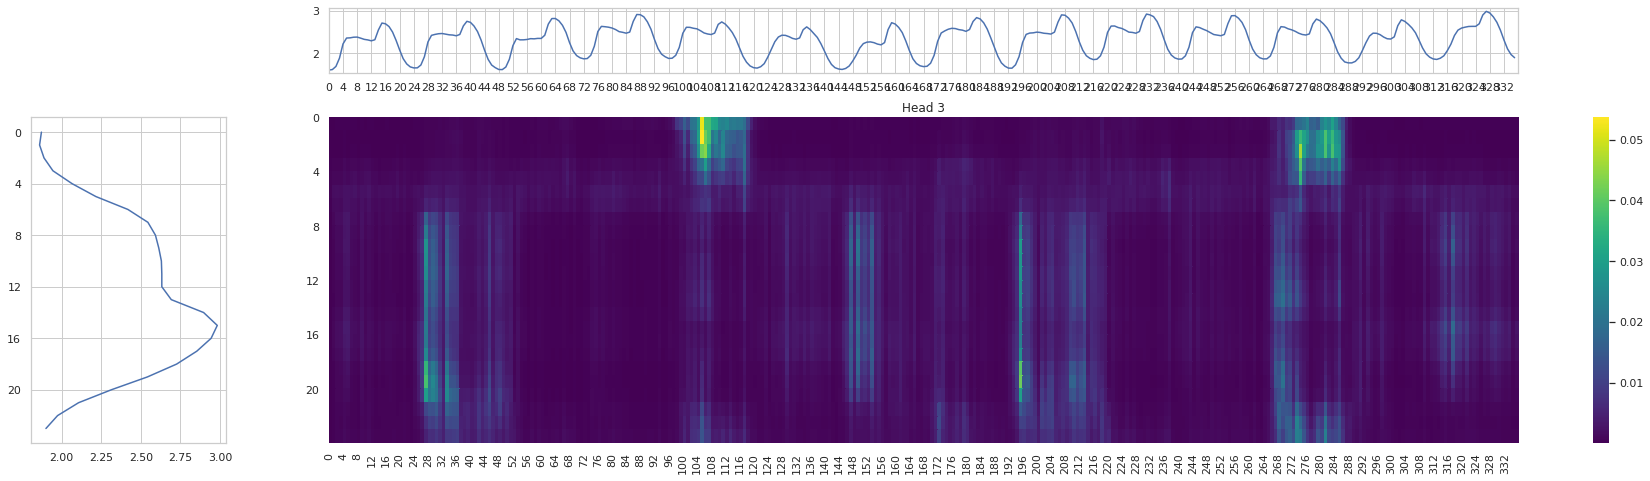

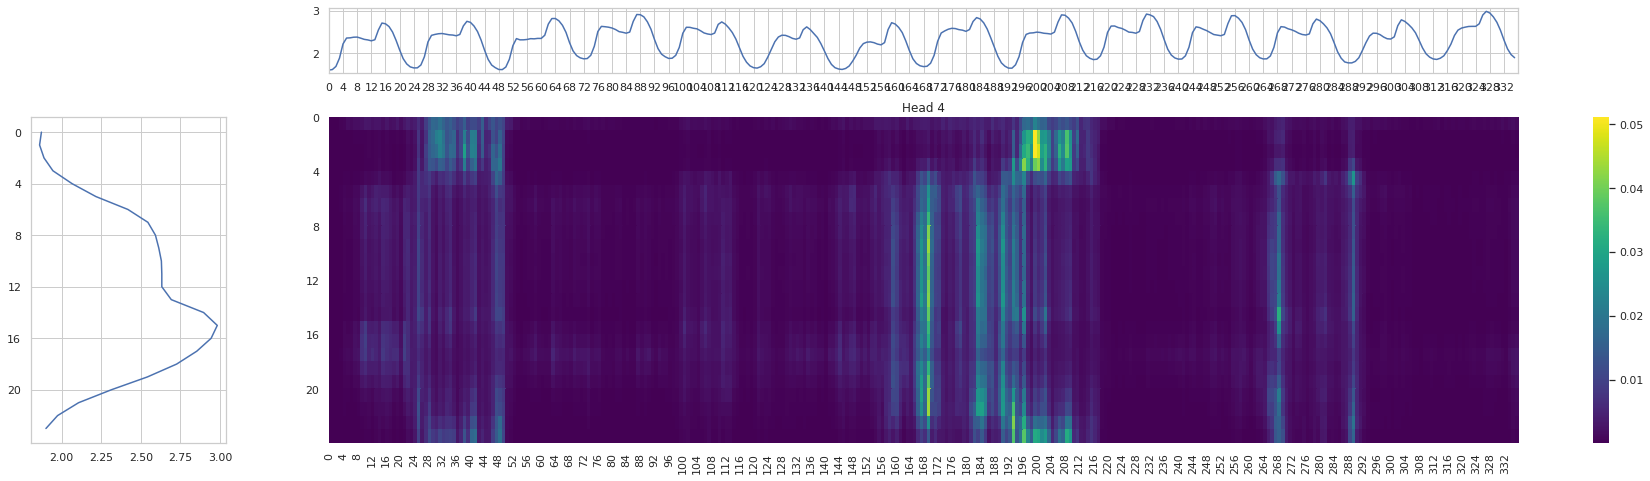

In [ ]:
idx = -10

num_steps_display = timesteps_in

attention = attention_weights
attention = tf.squeeze(attention["decoder_layer1_block2"][idx:idx+1], axis=0)

for head in range(0, num_heads):
  fig = plt.figure(figsize=(32,8))
  spec = gridspec.GridSpec(ncols=90, nrows=100)
  
  top_ax = fig.add_subplot(spec[0:15, 15:75])
  left_ax = fig.add_subplot(spec[25:, 0:10])
  right_ax = fig.add_subplot(spec[25:, 15:])
  
  top_ax.plot(x_train[idx, :num_steps_display, 0])
  top_ax.set_xlim([0, num_steps_display])
  top_ax.set_xticks(range(0, num_steps_display, 4))
  top_ax.set_xticklabels(range(0, num_steps_display, 4))

  left_ax.plot(decoder_input[idx, :, 0], range(0, timesteps_out))
  left_ax.set_yticks(range(0, timesteps_out, 4))
  left_ax.set_yticklabels(range(0, timesteps_out, 4))
  left_ax.invert_yaxis()

  sns.heatmap(attention[head][:, :num_steps_display], cmap="viridis", ax=right_ax)
  right_ax.set_xticks(range(0, num_steps_display, 4))
  right_ax.set_xticklabels(range(0, num_steps_display, 4))
  right_ax.set_yticks(range(0, timesteps_out, 4))
  right_ax.set_yticklabels(range(0, timesteps_out, 4))

  plt.title("Head {}".format(head+1))
  plt.show()

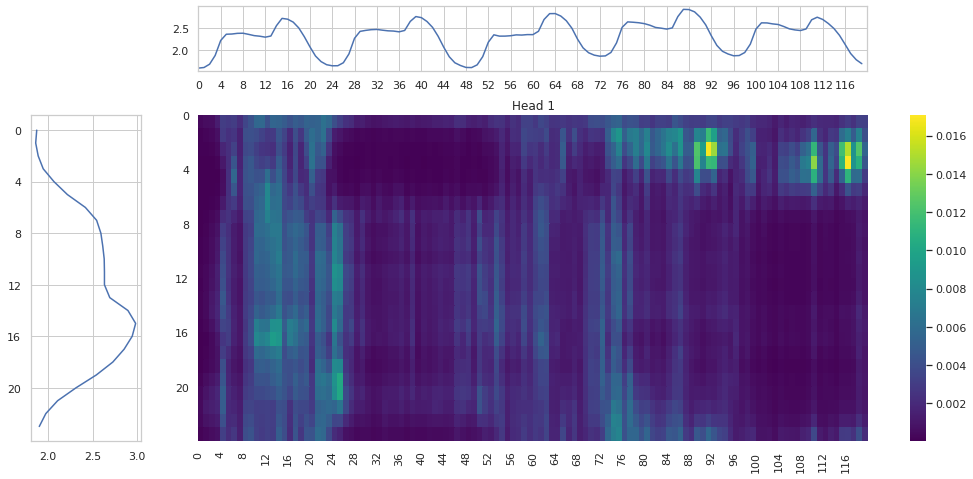

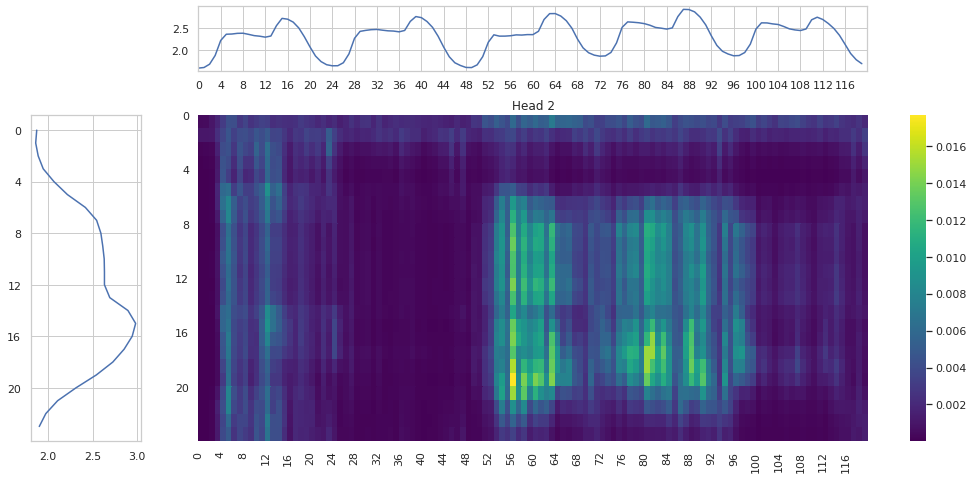

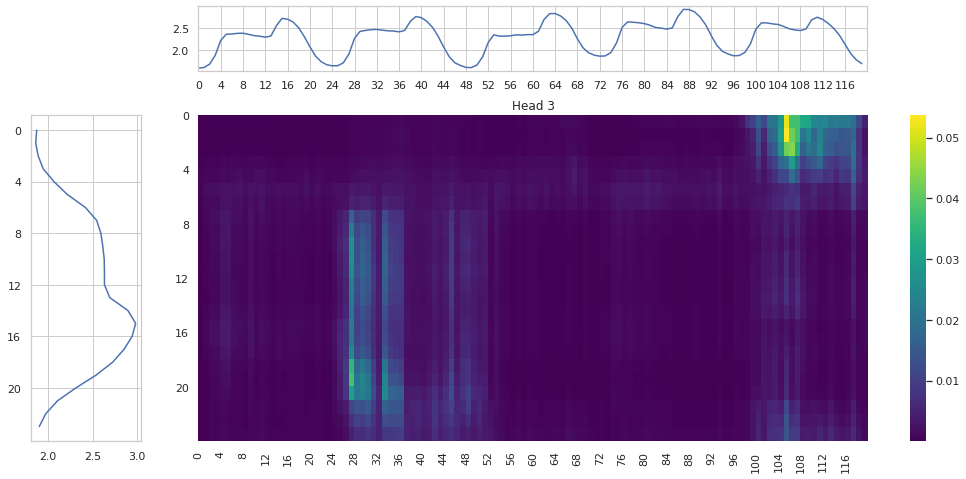

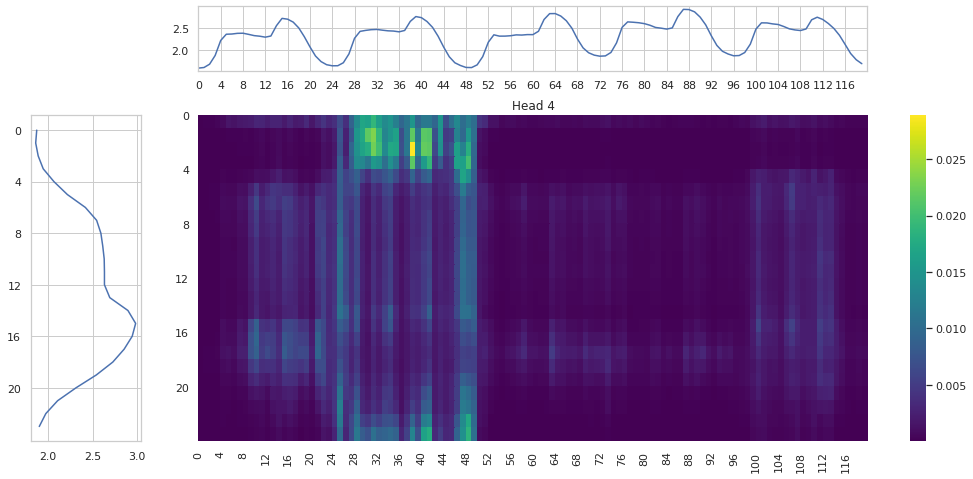

In [ ]:
idx = -10

num_steps_display = 120

attention = attention_weights
attention = tf.squeeze(attention["decoder_layer1_block2"][idx:idx+1], axis=0)

for head in range(0, num_heads):
  fig = plt.figure(figsize=(18,8))
  spec = gridspec.GridSpec(ncols=90, nrows=100)
  
  top_ax = fig.add_subplot(spec[0:15, 15:75])
  left_ax = fig.add_subplot(spec[25:, 0:10])
  right_ax = fig.add_subplot(spec[25:, 15:])
  
  top_ax.plot(x_train[idx, :num_steps_display, 0])
  top_ax.set_xlim([0, num_steps_display])
  top_ax.set_xticks(range(0, num_steps_display, 4))
  top_ax.set_xticklabels(range(0, num_steps_display, 4))

  left_ax.plot(decoder_input[idx, :, 0], range(0, timesteps_out))
  left_ax.set_yticks(range(0, timesteps_out, 4))
  left_ax.set_yticklabels(range(0, timesteps_out, 4))
  left_ax.invert_yaxis()

  sns.heatmap(attention[head][:, :num_steps_display], cmap="viridis", ax=right_ax)
  right_ax.set_xticks(range(0, num_steps_display, 4))
  right_ax.set_xticklabels(range(0, num_steps_display, 4))
  right_ax.set_yticks(range(0, timesteps_out, 4))
  right_ax.set_yticklabels(range(0, timesteps_out, 4))

  plt.title("Head {}".format(head+1))
  plt.show()

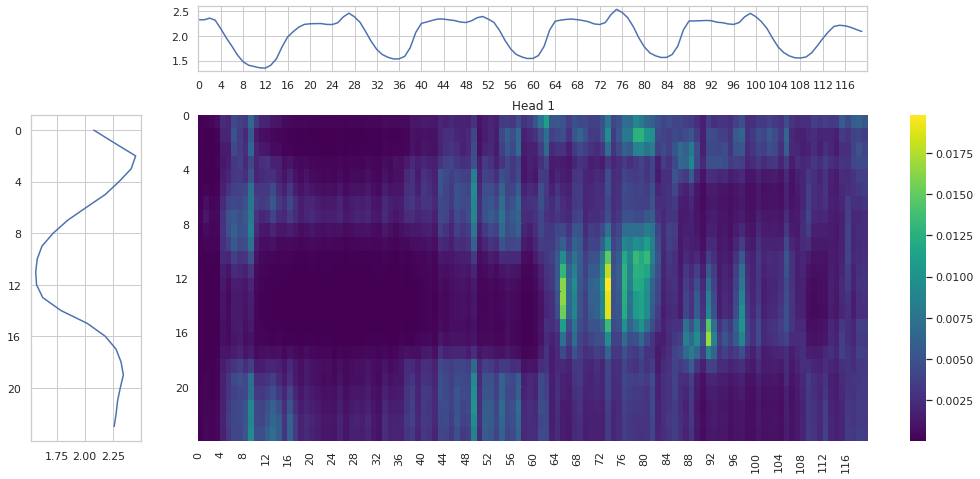

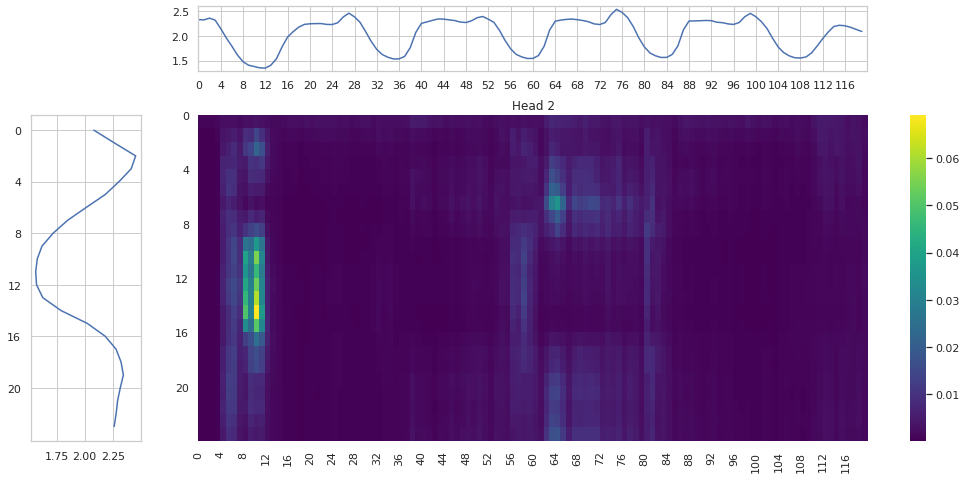

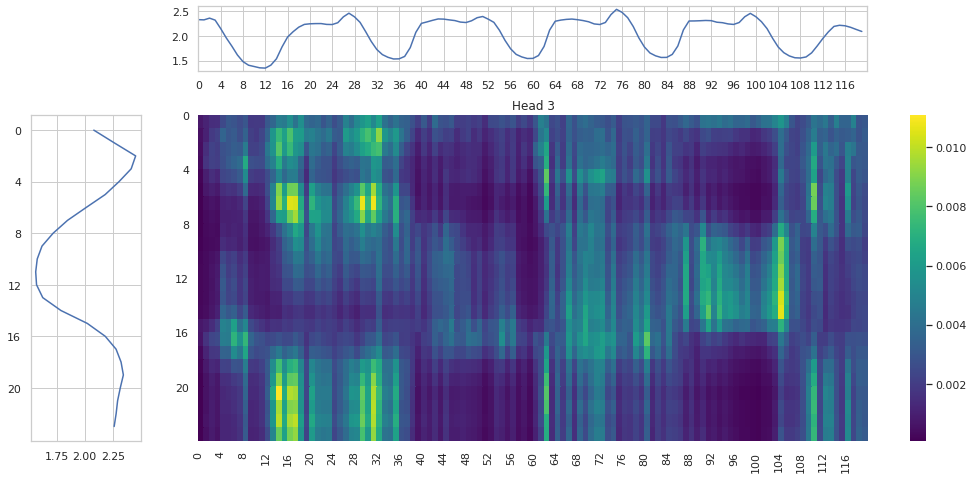

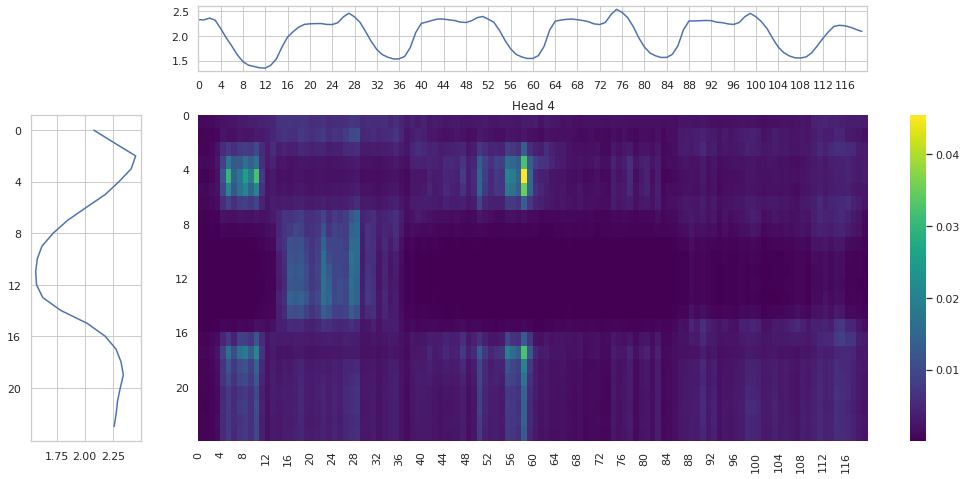

In [ ]:
idx = -15

num_steps_display = 120

attention = attention_weights
attention = tf.squeeze(attention["decoder_layer1_block2"][idx:idx+1], axis=0)

for head in range(0, num_heads):
  fig = plt.figure(figsize=(18,8))
  spec = gridspec.GridSpec(ncols=90, nrows=100)
  
  top_ax = fig.add_subplot(spec[0:15, 15:75])
  left_ax = fig.add_subplot(spec[25:, 0:10])
  right_ax = fig.add_subplot(spec[25:, 15:])
  
  top_ax.plot(x_train[idx, :num_steps_display, 0])
  top_ax.set_xlim([0, num_steps_display])
  top_ax.set_xticks(range(0, num_steps_display, 4))
  top_ax.set_xticklabels(range(0, num_steps_display, 4))

  left_ax.plot(decoder_input[idx, :, 0], range(0, timesteps_out))
  left_ax.set_yticks(range(0, timesteps_out, 4))
  left_ax.set_yticklabels(range(0, timesteps_out, 4))
  left_ax.invert_yaxis()

  sns.heatmap(attention[head][:, :num_steps_display], cmap="viridis", ax=right_ax)
  right_ax.set_xticks(range(0, num_steps_display, 4))
  right_ax.set_xticklabels(range(0, num_steps_display, 4))
  right_ax.set_yticks(range(0, timesteps_out, 4))
  right_ax.set_yticklabels(range(0, timesteps_out, 4))

  plt.title("Head {}".format(head+1))
  plt.show()